In [37]:
import pandas as pd
from sklearn.feature_selection import r_regression
import matplotlib.pyplot as plt
data = pd.read_csv("train.csv")
X, y, smiles = data.drop(["Tm","id","SMILES"], axis=1), data["Tm"], data["SMILES"]

In [38]:
X

,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,Group 8,Group 9,Group 10,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2660,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
smiles

0             FC1=C(F)C(F)(F)C1(F)F
1       c1ccc2c(c1)ccc3Nc4ccccc4c23
2               CCN1C(C)=Nc2ccccc12
3                        CC#CC(=O)O
4                         CCCCC(S)C
                   ...             
2657                         ClCCBr
2658                 N#CC(Cl)(Cl)Cl
2659             Cc1ccc2c(C)cccc2c1
2660          CCC(=O)c1ccc2ccccc2c1
2661              Brc1ccc(cc1)N(C)C
Name: SMILES, Length: 2662, dtype: object

Can put in some transformer to obtain additional prediction

In [40]:
y

0       213.15
1       407.15
2       324.15
3       351.15
4       126.15
         ...  
2657    256.45
2658    231.15
2659    256.25
2660    333.15
2661    328.15
Name: Tm, Length: 2662, dtype: float64

Top 50 variables most correlated with the target:
Group 15     0.387580
Group 18     0.223551
Group 16     0.223530
Group 401    0.222525
Group 17     0.194420
Group 1      0.186595
Group 123    0.179178
Group 365    0.176346
Group 31     0.171773
Group 412    0.165621
Group 30     0.162579
Group 5      0.158361
Group 326    0.151604
Group 62     0.150432
Group 373    0.129026
Group 403    0.125958
Group 126    0.122881
Group 221    0.120362
Group 180    0.114525
Group 19     0.110682
Group 392    0.110205
Group 7      0.109899
Group 119    0.109563
Group 227    0.109124
Group 32     0.107192
Group 372    0.106768
Group 80     0.106296
Group 3      0.104648
Group 229    0.104042
Group 170    0.101924
Group 328    0.100826
Group 98     0.099892
Group 20     0.099776
Group 53     0.096433
Group 175    0.093156
Group 176    0.091605
Group 2      0.089414
Group 409    0.087669
Group 129    0.086298
Group 222    0.085987
Group 367    0.085266
Group 388    0.085180
Group 86     0.084960
Grou

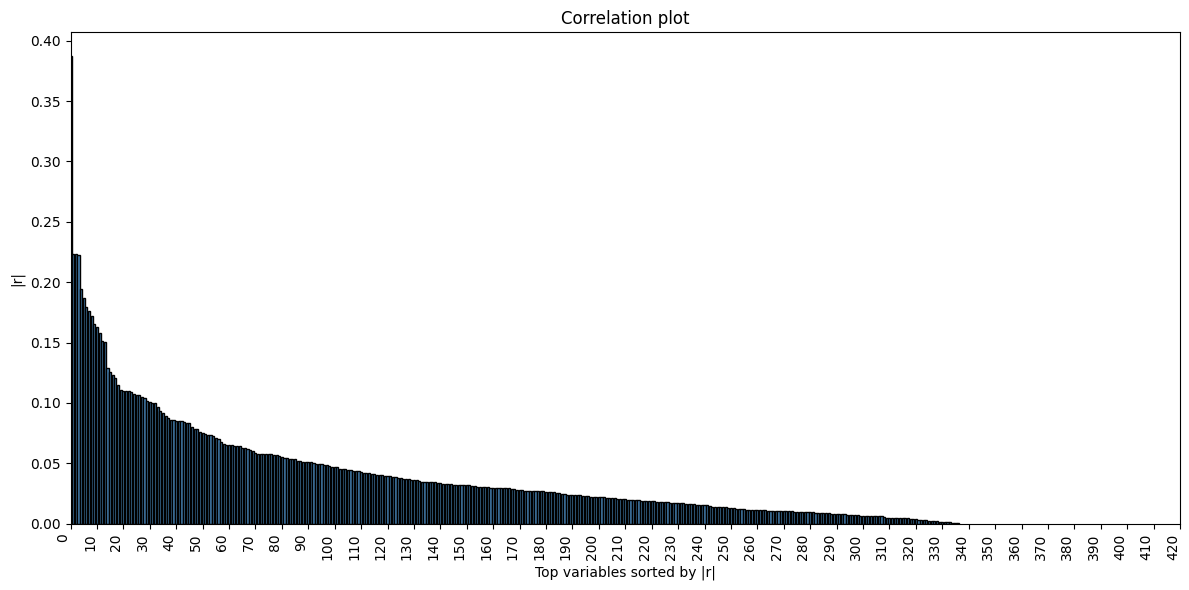

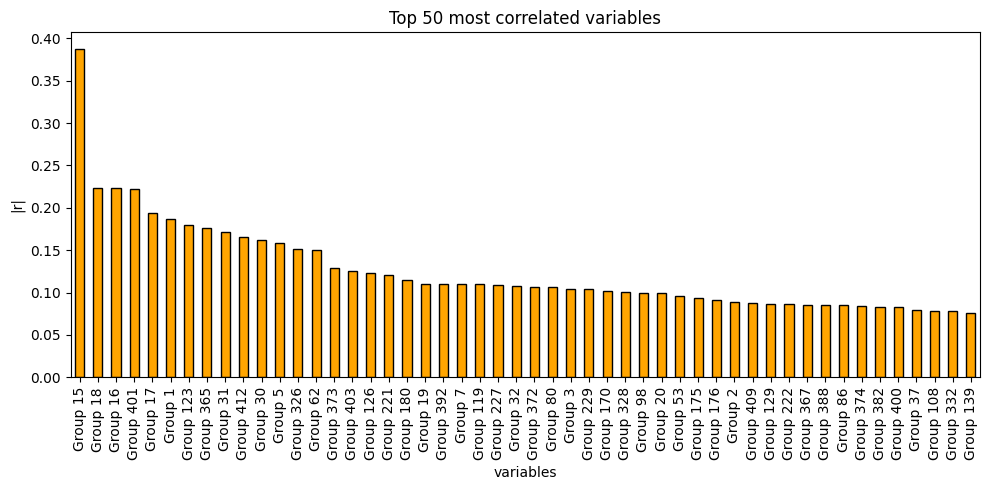

In [41]:
df_corr = pd.concat([X, y], axis=1).select_dtypes(include='number')

correlations = df_corr.corr(numeric_only=True)['Tm'].drop('Tm')

abs_corr = correlations.abs().sort_values(ascending=False)

top50 = abs_corr.head(50)

print("Top 50 variables most correlated with the target:")
print(top50)


plt.figure(figsize=(12, 6))
plt.bar(range(len(abs_corr)), abs_corr.values, color='steelblue', edgecolor='black')
plt.title("Correlation plot")
plt.ylabel("|r|")
plt.xlabel("Top variables sorted by |r|")

step = 10
xticks_idx = range(0, len(abs_corr), step)
plt.xticks(xticks_idx, xticks_idx, rotation=90, ha='right')
plt.xlim(0, 420)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top50.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Top 50 most correlated variables")
plt.ylabel("|r|")
plt.xlabel("variables")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

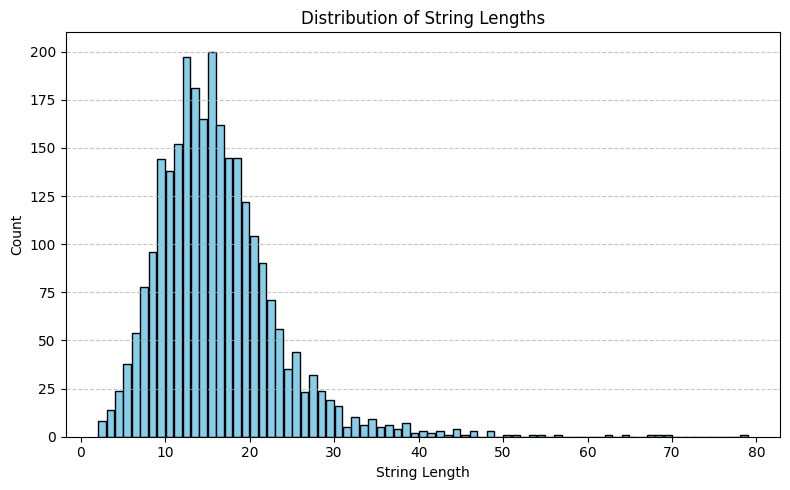

In [42]:
texts = smiles.tolist()
# Compute string lengths
lengths = [len(t) for t in texts]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 2), color='skyblue', edgecolor='black', rwidth=0.9)

plt.title("Distribution of String Lengths")
plt.xlabel("String Length")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Cut to 50 is reasonable

In [43]:
X[top50.index]

,Group 15,Group 18,Group 16,Group 401,Group 17,Group 1,Group 123,Group 365,Group 31,Group 412,...,Group 367,Group 388,Group 86,Group 374,Group 382,Group 400,Group 37,Group 108,Group 332,Group 139
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,0,2,2,4,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,1,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,6,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2660,7,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Evaluate 5-fold CV MAE for different top feature counts
for n in range(10,420,10):
    top_features = abs_corr.head(n).index

    model = LinearRegression()
    
    # 5-fold cross-validation, scoring='neg_mean_absolute_error'
    scores = cross_val_score(model, X[top_features], y, cv=10, scoring='neg_mean_absolute_error')
    
    mae_mean = -scores.mean()  # negate because scores are negative
    mae_std = scores.std()
    
    print(f"Top {n} features → 5-fold CV MAE: {mae_mean:.4f} ± {mae_std:.4f}")


Top 10 features → 5-fold CV MAE: 55.4026 ± 1.8828
Top 20 features → 5-fold CV MAE: 50.6283 ± 2.4304
Top 30 features → 5-fold CV MAE: 48.8196 ± 2.6177
Top 40 features → 5-fold CV MAE: 45.8942 ± 2.5269
Top 50 features → 5-fold CV MAE: 44.6979 ± 2.3409
Top 60 features → 5-fold CV MAE: 44.3393 ± 2.3515
Top 70 features → 5-fold CV MAE: 44.0362 ± 2.4129
Top 80 features → 5-fold CV MAE: 43.9061 ± 2.1370
Top 90 features → 5-fold CV MAE: 1850062775.7812 ± 5550188197.1494
Top 100 features → 5-fold CV MAE: 43.6169 ± 2.4287
Top 110 features → 5-fold CV MAE: 43.3516 ± 2.2590
Top 120 features → 5-fold CV MAE: 8552320357.5821 ± 25656960945.2265
Top 130 features → 5-fold CV MAE: 42.2208 ± 2.1311
Top 140 features → 5-fold CV MAE: 7301888741.6702 ± 21905666099.8605
Top 150 features → 5-fold CV MAE: 2212705792.7358 ± 6638117253.6174
Top 160 features → 5-fold CV MAE: 25135530865.0111 ± 75406592471.1843
Top 170 features → 5-fold CV MAE: 28065807557.1333 ± 84197422225.5278
Top 180 features → 5-fold CV MAE: 

ValueError: x and y must be the same size

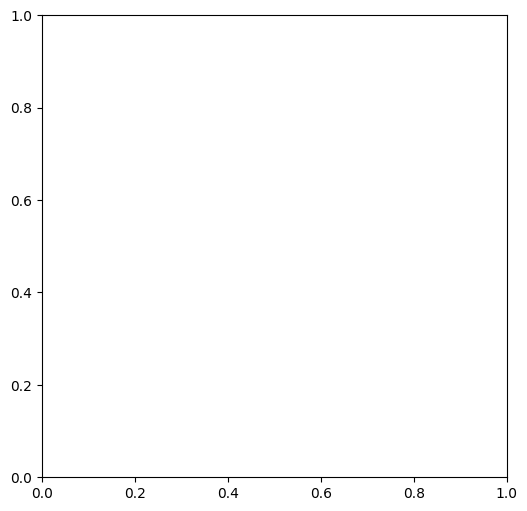

In [45]:

# Assuming you already have:
# y_test (true values)
# y_pred (predicted values)
y_test = y
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='steelblue', alpha=0.6, edgecolor='k')

plt.title("Actual vs Predicted Values")
plt.xlabel("Actual (True) Values")
plt.ylabel("Predicted Values")
plt.tight_layout()
plt.show()


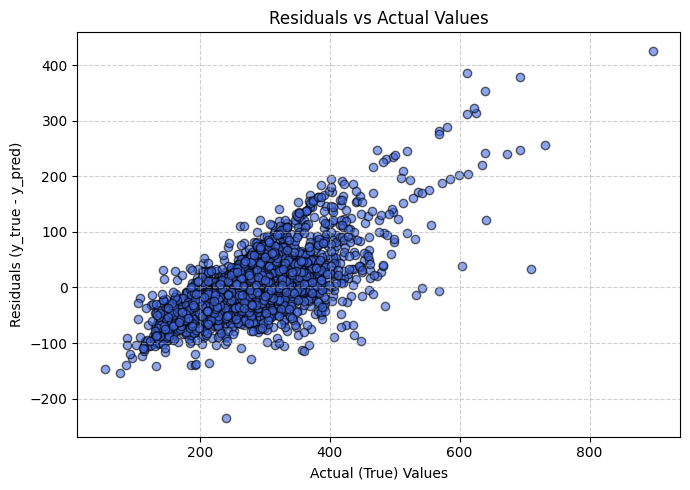

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_test, residuals, color='royalblue', alpha=0.6, edgecolor='k')
#plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title("Residuals vs Actual Values")
plt.xlabel("Actual (True) Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()